# 利用Python Class构造Kalman滤波器


其基本思路是：

新的最佳估计基于**原最佳估计**和**已知外部影响校正**后得到的预测。

新的不确定性基于**原不确定性**和**外部环境的不确定性**得到的预测。

![Kalman Filter公式](Kalman_Filter.png)

下面这个是根据上图中的公式写的，应该可以用于EKF，参考[360doc 时钟转动 / 卡尔曼滤波 / Kalman滤波器的C++实现 ](http://www.360doc.com/content/19/1230/15/67736081_883122769.shtml)

In [100]:
import numpy as np
import math
# import scipy.stats as st
# import scipy
# import matplotlib as mpl
import matplotlib.pyplot as plt

class KalmanFilter:
    stateSize = 1
    measureSize = 1
    controlSize = 0
    x,z,A,B,G,u,Px,K,Hz,Qv,Rm = [0,0,0,0,0,0, 0,0,0,0,0]
    
    def __init__(self,n,m,nc):
        self.stateSize = n
        self.measureSize = m
        self.controlSize = nc
        self.x = np.zeros([n,1])
        self.z = np.zeros([m,1])
        
        self.In = np.eye(n)
        self.A = np.eye(n)         # state transition matrix, discrete
        if nc>0:
            self.u = np.zeros([nc,1])
            self.B = np.zeros(n,nc)
        
        self.G = np.eye(n)
        self.Px = np.eye(n)*1e-6
        self.Qv = 1e-6*np.eye(n)  # process variance
        self.K  = np.zeros([n,m]) # kalman gain
        self.Hz = np.zeros([m,n])
        self.Rm = 1e-6*np.eye(m)  # estimate of measurement variance,
    
    def init(self,x_,P_,Q_,R_):
        for i in range(0,self.stateSize):
            self.x[i,:] = x_[i,:]
        self.Px = P_
        self.Qv = Q_
        self.Rm = R_
        return self
    
    def predict(self,A_):
        self.A = A_
        self.x = self.A@self.x
#         print(self.x)
        self.P = self.A@self.Px@self.A.T + self.G@self.Qv@self.G.T 
        return self
    
    def update(self,H_,z_):
        self.Hz = H_
        Ht = self.Hz.T
        temp1 = self.Hz@self.P@Ht + self.Rm
#         temp2 = temp1.inverse() #(H*P*H'+R)^(-1)
        self.K = self.P@Ht@np.linalg.inv(temp1)
        self.z = z_
        z_predict = self.Hz@self.x
        self.x = self.x + self.K@(self.z - z_predict)
#         print(self.x)
        self.P = (self.In - self.K@self.Hz)@self.Px
        return self
    

## 线性动力学、线性观测
以下是一个一维Doppler测速估计目标状态的模型：
$$
\begin{aligned}
&\dot{x}=Ax+\nu =\left[\begin{array}{l}
\dot{r} \\
\dot{v}
\end{array}\right]=\left[\begin{array}{ll}
0 & 1 \\
0 & 0
\end{array}\right]\left[\begin{array}{l}
r \\
v
\end{array}\right]+\left[\begin{array}{ll}
v_{1}\\
v_{2}
\end{array}\right] 
\\
&z = Hx +w=\left[\begin{array}{ll}
0 & 1
\end{array}\right]\left[\begin{array}{r}
r \\
v
\end{array}\right]+w_1
\end{aligned}
$$
然后协方差矩阵定义为： $$
\operatorname{Cov}(\hat{x}-x)=P \ ,\ \operatorname{Cov}([v_1,v_2])=Q \ ,\ \operatorname{Cov}(w_1)=R
$$
目标初始时刻$x(0) \approx 0$, 已知目标是匀速直线运动，要求用KF估计其速度。

In [106]:
def calExpAt(A,dt):
    n = len(A)
    I = np.eye(n)
    return I+A*dt+A@A/2*dt*dt

#########################################################################
# 系统设置，初值估计
#########################################################################
measureStep = 0.1;
tf = 30;
lth = 1 + int(tf/measureStep);
ts = np.linspace(0,tf,lth)
a
A = np.array([[0,1.0],[0,0]])           # system matrix
H = np.array([[0,1.0]])                 # 注意size

x0 = np.array([0,0])                  # 我这里随意设置了一个初值，与真实值相差较大
x0 = x0[:,np.newaxis]
# x0 = np.array([[x1],[x2]]) 
#########################################################################
# 先验统计误差，
#########################################################################
sigmaQv = (0.1,1)                     # estimated pertubation of dynamical system per step
                                        # 如果第一步的初始状态估计误差就很大，这里就需要设置稍大；否则，收敛将很慢
Q = np.eye(2)
Q[0,0] = Q[0,0]*sigmaQv[0]**2           # pertubation from white noise, may be from 
Q[1,1] = Q[1,1]*sigmaQv[1]**2
sigmaRm = 0.1                           # a priori precision of measurement
R = np.array([[sigmaRm**2]])            # covariance of measurement precision

P0 = np.eye(2)                          # error of state, estimated at start
P0[0,0] = 1*P0[0,0]
P0[1,1] = 3*P0[1,1]*sigmaRm**2    
#########################################################################
# 采用先验误差设定，模拟真实的、带有噪声的测量数据
#########################################################################
# z_ts = np.linspace(0,18,lth)+np.random.normal(0,sigmaRm,lth)  # 匀加速
v = 1.2
z_real = v*np.ones((lth))               # 一维数组，尚未扩充维度到2
z_ts = z_real+np.random.normal(0,sigmaRm*sigmaRm,lth)
z_ts = z_ts[np.newaxis, :]              # 作为行向量输入

In [32]:
x0

array([[0.],
       [1.]])

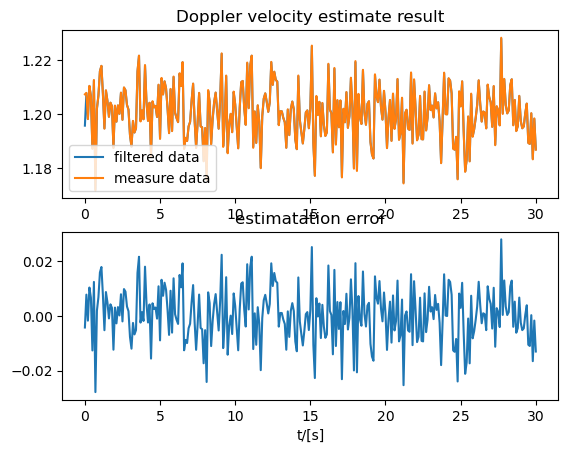

In [107]:
# 创建并初始化
dopp = KalmanFilter(2,1,0)
# 设置先验误差矩阵
dopp.init(x0,P0,Q,R)

# 保存数据
# P_ts = P[:,:,np.newaxis]
x_ts = np.zeros([lth,2])

for it in range(0,lth):
    dopp.predict(calExpAt(A,measureStep))
    dopp.update(H,z_ts[:,it,np.newaxis])
    x_ts[it,:] = dopp.x.T[0]
    # x_ts[0,it] = dopp.x[0],x_ts[1,it] = dopp.x[1]
    
# 绘图
plt.subplot(2,1,1)
plt.plot(ts,x_ts[:,1])
plt.plot(ts,z_ts[0])
plt.legend(['filtered data', 'measure data'])
plt.title('Doppler velocity estimate result')

plt.subplot(2,1,2)
plt.plot(ts,x_ts[:,1]-z_real)
plt.xlabel('t/[s]')
plt.title('estimatation error')
plt.show()



标准差$$
S=\sqrt{\frac{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)^{2}}{n-1}}
$$

In [103]:
# 统计一下估计误差
v_hat = x_ts[-100:,1]
err = v_hat-z_real[-100:]
std = np.sum((err- np.mean(err))**2)/99
print('estimated covariance of navigation: ',math.sqrt(std))

estimated covariance of navigation:  9.456582403405152e-05


## 时变线性系统、非线性观测
二维平面内的地基导航设备跟踪飞行器：
目标运动学方程$X\triangleq[x,y,v,\theta]$,
$$
\left\{\begin{array}{c}
\dot x= v\cos\theta \\
\dot y = v\sin\theta \\
\dot v = u_t + v_1\\
\dot \theta = u_n/v + v_2
\end{array}\right.
$$
量测方程
$$
\boldsymbol{Z}(k)\triangleq
\left[\begin{array}{c}
\rho \\
El
\end{array}\right]=
h\left(\boldsymbol{X}_{k}\right)+\boldsymbol{\omega}(k)= 
\left[\begin{array}{c}
\sqrt{x_{k}^{2}+y_{k}^{2}} \\
\arctan \left(y_{k} / x_{k}\right) \\
\end{array}\right]+
\left[\begin{array}{c}
w^{\rho} \\
w^{El}
\end{array}\right]
$$
线性化：
$$A=\left[\begin{array}{c}
0 & 0 & \cos\theta & -v\sin\theta \\
0 & 0 & \sin\theta & v\cos\theta \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{array}\right], 
B=\left[\begin{array}{ll}
0 & 0 \\
0 & 0 \\
1 & 0 \\
0 & \frac{1}{v}
\end{array}\right],
H=\left[\begin{array}{c}
\frac{x}{\rho} & \frac{y}{\rho} & 0 & 0 \\
-\frac{y}{\rho^{2}} & \frac{x}{\rho^{2}} & 0 & 0
\end{array}\right]
$$

In [93]:
def calA(X):
    n = len(X)
    A = np.zeros([n,n])
    A[0,2],A[0,3],A[1,2],A[1,3]=(math.cos(X[3]),-X[2]*math.sin(X[3]),math.sin(X[3]),X[2]*math.cos(X[3]))
    return A

def calH(X):
    n = len(X)
    m = 2
    H = np.zeros([m,n])
    rho2 = X[0]**2+X[1]**2
    rho = math.sqrt(rho2)
    H[0,0],H[0,1],H[1,0],H[1,1]=(X[0]/rho,X[1]/rho,-X[1]/rho2,X[0]/rho2)
    return H

def calCovXY(x,y,covRhoEl):
    # covXY =  np.zeros([2,2])
    rho2 = math.sqrt(x**2+y**2)
    rho = math.sqrt(rho2)
    PxyPre =  np.array([[x/rho,y/rho],[-y/rho2,x/rho2]])
    covXY = PxyPre@covRhoEl@PxyPre.T
    return covXY

def calExpAt(A,dt):
    n = len(A)
    I = np.eye(n)
    # return I+A*dt+A@A/2*dt*dt+A@A@A/6*dt*dt*dt
    return I+A*dt

#########################################################################
# 系统设置，初值估计
#########################################################################
measureStep = 0.01
tf = 10
lth = 1 + int(tf/measureStep)
ts = np.linspace(0,tf,lth)

x0_real = np.array([5.0,12.0,0.8,-0.64])     # 这是设定中的真实状态初始值
# x0 = np.array([[x1],[x2]]) 
dx0 = np.array([0.1,0.2,0.01,-0.04])         # 我这里随意设置了一个偏差
x0 = x0_real + dx0                           # 初值
x0 = x0[:,np.newaxis]


# A = calA([4,3,1,0.5])                        # system matrix
# H = np.array([])                             # 注意size
Gamma = np.zeros([4,2])
Gamma[2,0],Gamma[3,1] = (1,1)
# z0 = np.array([5,0.64])
# z0 = z0[:,np.newaxis]
#########################################################################
# 先验统计误差，
#########################################################################
dvth = np.array([0.8,0.1])              # pertubation 0.8[m/s]/s,0.1[rad]/s
sigmaQv = dvth*measureStep              # estimated pertubation of dynamical system per step, 
Q = np.eye(2)
Q[0,0] = Q[0,0]*sigmaQv[0]**2           # pertubation from white noise, may be from ？？？
Q[1,1] = Q[1,1]*sigmaQv[1]**2

# dxy = 0.05                            # 二维平面内的定位误差，$x,y$而非$v,th$
sigmaRm = np.array([0.05,1.0/57.3])      # a priori precision of measurement sigma = 0.05[m],1[deg]
R = np.array([[sigmaRm[0]**2,0],[0,sigmaRm[1]**2]])            # covariance of measurement precision
CovXY = calCovXY(x0[0,0],x0[1,0],R)

P0 =  np.eye(4)                         # error of state, estimated at start
P0[0,0] = 100*P0[0,0]*CovXY[0,0]        
P0[1,1] = 100*P0[1,1]*CovXY[1,1]
P0[2,2] = 10*P0[2,2]*sigmaQv[0]**2         
P0[3,3] = 10*P0[3,3]*sigmaQv[1]**2


有关EKF的理论内容，可以参考[GHelpU - 卡尔曼滤波系列——（二）扩展卡尔曼滤波 - CSDN博客](https://blog.csdn.net/weixin_42647783/article/details/89054641)，需要注意的是，EKF和KF的主要区别在于观测方程的非线性，虽然动力学也是非线性的，但是可以通过线性化近似为时变线性系统，但是观测方程是不可线性化的，否则就容易发散。

针对如上区别，对上面KF的模型做了简单的改写，它可以按照问题类型选择``self.observe``的调用函数$z = h(x)$，而非直接$z = Hx$：

In [94]:
import numpy as np
import math
# import scipy.stats as st
# import scipy
# import matplotlib as mpl
import matplotlib.pyplot as plt

class EKalmanFilter:
    stateSize = 1
    measureSize = 1
    controlSize = 0
    IsNonLinearObserve , funHz = (0, '')
    x,z,A,B,G,u,Px,K,Hz,Qv,Rm = [0,0,0,0,0,0, 0,0,0,0,0]
    
    def __init__(self,n,m,nc):
        self.stateSize = n
        self.measureSize = m
        self.controlSize = nc
        self.x = np.zeros([n,1])
        self.z = np.zeros([m,1])
        
        self.In = np.eye(n)
        self.A = np.eye(n)         # state transition matrix, discrete
        if nc>0:
            self.u = np.zeros([nc,1])
            self.B = np.zeros(n,nc)
        
        self.G = np.eye(n)
        self.Px = np.eye(n)*1e-6
        self.Qv = 1e-6*np.eye(n)  # process variance
        self.K  = np.zeros([n,m]) # kalman gain
        self.Hz = np.zeros([m,n])
        self.Rm = 1e-6*np.eye(m)  # estimate of measurement variance,
    
    def init(self,x_,P_,Q_,R_):
        for i in range(0,self.stateSize):
            self.x[i,:] = x_[i,:]
        self.Px = P_
        self.Qv = Q_
        self.Rm = R_
        return self
    
    def predict(self,A_):
        self.A = A_
        self.x = self.A@self.x
#         print(self.x)
        self.P = self.A@self.Px@self.A.T + self.G@self.Qv@self.G.T 
        return self

    def observe(self,x):
        if self.IsNonLinearObserve:
            z = self.funHz(x)
            z_predict = np.array( [ [z[0]], [z[1]] ] )
        else:
            z_predict = self.Hz@x

        return z_predict

    def update(self,H_,z_):
        self.Hz = H_
        Ht = self.Hz.T
        temp1 = self.Hz@self.P@Ht + self.Rm
#         temp2 = temp1.inverse() #(H*P*H'+R)^(-1)
        self.K = self.P@Ht@np.linalg.inv(temp1)

        self.z = self.observe(self.x)

        self.x = self.x + self.K@(z_ - self.z)
#         print(self.x)
        self.P = (self.In - self.K@self.Hz)@self.Px
        return self

求解运动学方程，将真实状态代入观测方程，模拟雷达的观测数据

In [95]:
#########################################################################
# 采用准确的系统方程，模拟真实的状态
#########################################################################

#-----------------------------------------------------------------------------
"""A variety of methods to solve first order ordinary differential equations.

AUTHOR:
    Jonathan Senning <jonathan.senning@gordon.edu>
    Gordon College
    Based Octave functions written in the spring of 1999
    Python version: March 2008, October 2008
"""
#-----------------------------------------------------------------------------

def euler( f, x0, t ):
    """Euler's method to solve x' = f(x,t) with x(t[0]) = x0.
    """

    n = len( t )
    x = np.array( [x0] * n )
    for i in range( n - 1 ):
        x[i+1] = x[i] + ( t[i+1] - t[i] ) * f( x[i], t[i] )

    return x

#-----------------------------------------------------------------------------


def system( X, t ):
    eta1, eta2 = np.random.normal(0,sigmaQv*sigmaQv,2)
    return np.array([X[2]*math.cos(X[3]),X[2]*math.sin(X[3]),eta1,eta2/X[2]])# no control 

x_euler = euler( system, x0_real, ts )


#########################################################################
# 采用先验的测量方程，模拟带有噪声的测量数据
#########################################################################
def radarRangeElevation(x):
    return np.array([math.sqrt(x[0]**2+x[1]**2),math.atan(x[1]/x[0])])

def measurement( ts , x_euler , z0):
    n = len( ts )
    z = np.array( [z0] * n )
    for i in range (n):
        w1, w2 = np.random.normal(0,sigmaRm*sigmaRm,2)
        z[i,0] = math.sqrt(x_euler[i,0]**2+x_euler[i,1]**2) + 10*w1
        z[i,1] = math.atan(x_euler[i,1]/x_euler[i,0])+ 10*w2

    return z

z0 = np.array([13,1.2])               # 对应于准确初始状态的准确测量结果
z_ts = measurement( ts , x_euler , z0)


In [88]:
z_ts

array([[13.04840972,  1.17467356],
       [12.71547004,  1.17518125],
       [12.94781095,  1.17173242],
       ...,
       [12.27181277,  0.53177892],
       [12.32376193,  0.53242887],
       [12.17766758,  0.53496108]])

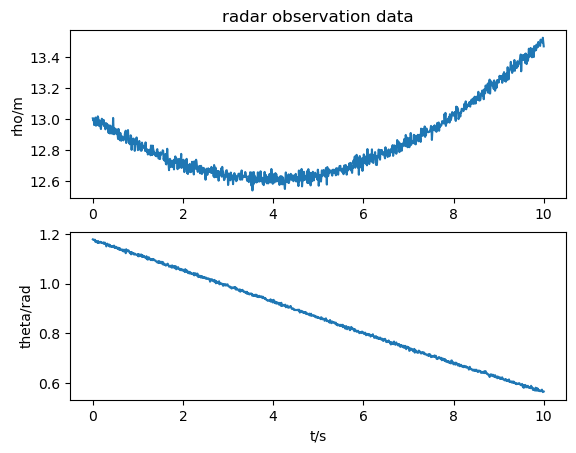

In [96]:
# import matplotlib.pyplot as plt
plt.subplot(2,1,1)
plt.plot(ts,z_ts[:,0])
plt.ylabel('rho/m')
# ax.set_ylabel('$\rho$/m')
# plt.xlabel('t/s')
# plt.legend(['$\phi_{%d}(x)$' % i for i in range(1, degree + 1)], loc='best');
# plt.legend(['real data', 'estimated data'])
# ax.set_title('radar observation data')
plt.title('radar observation data')

plt.subplot(2,1,2)
plt.plot(ts,z_ts[:,1])
# ax.set_xlabel('$t/s$')
# ax.set_ylabel('$\theta$/rad')
plt.xlabel('t/s')
plt.ylabel('theta/rad')
# plt.legend(['real data', 'estimated data'])
plt.show()

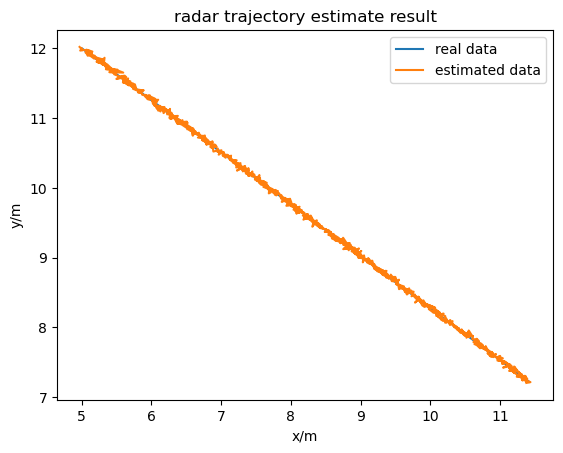

In [97]:
#########################################################################
# EKF
#########################################################################

# 创建并初始化
radar = EKalmanFilter(4,2,0)

dx0 = np.array([0.1,0.2,0.01,-0.04])                   # 我这里随意设置了一个初值，与真实值相差较大
dx0 = dx0[:,np.newaxis]
# 设置先验误差矩阵
radar.init(x0 ,P0,Q,R)
radar.G  = Gamma
radar.IsNonLinearObserve = 1
radar.funHz = radarRangeElevation
# 保存数据
# P_ts = P[:,:,np.newaxis]
x_ts = np.zeros([lth,4])

for it in range(0,lth):
    x_ = radar.x.T[0]                     # 转化为行向量（1维Array）再输入计算矩阵
    A = calA(x_)
    H = calH(x_)
    radar.predict(calExpAt(A,measureStep))
    radar.update(H,z_ts[it,:,np.newaxis])
    x_ts[it,:] = radar.x.T[0]
    # x_ts[0,it] = dopp.x[0],x_ts[1,it] = dopp.x[1]
    

#########################################################################
# 绘图
#########################################################################
plt.plot(x_euler[:,0],x_euler[:,1])
plt.plot(x_ts[:,0],x_ts[:,1])
plt.ylabel('y/m')
plt.xlabel('x/m')
plt.legend(['real data', 'estimated data'])
plt.title('radar trajectory estimate result')
plt.show()


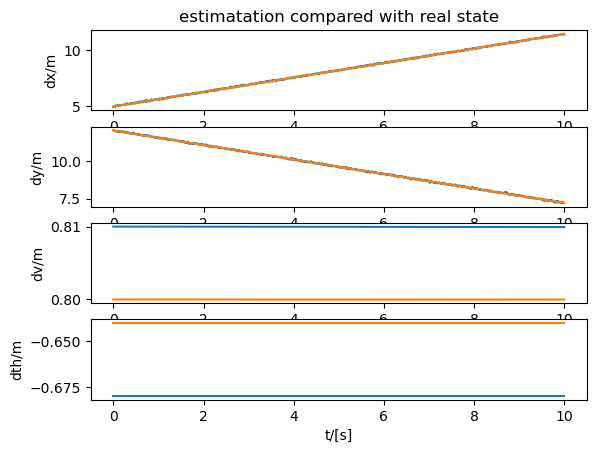

In [99]:
plt.subplot(4,1,1)
plt.plot(ts,x_ts[:,0],ts,x_euler[:,0])
plt.ylabel('dx/m')
plt.title('estimatation compared with real state')
plt.subplot(4,1,2)
plt.plot(ts,x_ts[:,1],ts,x_euler[:,1])
plt.ylabel('dy/m')
plt.subplot(4,1,3)
plt.plot(ts,x_ts[:,2],ts,x_euler[:,2])
plt.ylabel('dv/m')
plt.subplot(4,1,4)
plt.plot(ts,x_ts[:,3],ts,x_euler[:,3])
plt.ylabel('dth/m')
plt.xlabel('t/[s]')
plt.show()